In [2]:
from Bio import SeqIO
from re import search

def primerDetection(input_file, primerF, primerR):
    # Read all sequences from a fasta file and store them in a dictionary with their IDs as keys and sequences as values
    seq_dict = {rec.id : rec.seq for rec in SeqIO.parse(input_file, "fasta")}
    outf= str(input_file).split(".")[0]
    # Open the output files using "with open", this ensures files are closed properly even if an error occurs
    with open(outf + "_nolong.fasta", "a") as f, open(outf + "_long.fasta", "a") as g:
        for id, seq in seq_dict.items():  # Iterate over each sequence in the dictionary
            seq_str = str(seq)  # Convert sequence to string
            rev_com = seq.reverse_complement()  # Calculate reverse complement of sequence
            # Determine the output file based on sequence length
            outfile = f if len(seq_str) <= 6000 else g

            # If the forward primer is found in the sequence
            if search(primerF, seq_str):
                # Write the sequence ID and sequence to the appropriate output file
                print(">" + id, file=outfile)
                print(seq_str, file=outfile)
            # If the reverse primer is found in the sequence
            elif search(primerR, seq_str):
                # Write the sequence ID and reverse complement sequence to the appropriate output file
                print(">" + id, file=outfile)
                print(str(rev_com), file=outfile)

In [3]:
import subprocess
from Bio import SeqIO


def mafftRaw(input_file):
    # Define the MAFFT command as a list of strings
    mafft_command = ["mafft", "--reorder", "--thread", "30", input_file]
    outf= str(input_file).split("_")[0] + "_mafftRaw.fasta"
    # Use subprocess to run the command and redirect the output to a file
    with open(outf, 'w') as outfile:
        subprocess.run(mafft_command, stdout=outfile)

def mafftFinal(list_files):
    for input_file in list_files:
        # Define the MAFFT command as a list of strings
        mafft_command = ["mafft", "--reorder", "--thread", "30", input_file]
        outf= str(input_file).split(".")[0] + "_mafftFinal.fasta"
        # Use subprocess to run the command and redirect the output to a file
        with open(outf, 'w') as outfile:
            subprocess.run(mafft_command, stdout=outfile)

In [4]:
from Bio import SeqIO  # Importing SeqIO from BioPython for parsing sequences.

# This function converts a nucleotide to its binary representation.
# It could be optimized by using a dictionary instead of multiple if/elif statements.
def nucleotide_to_binary(nucleotide):
    nucleotide = nucleotide.upper()  # Convert nucleotide to upper case to remove redundancy
    if nucleotide == "A":
        return "1,0,0,0"
    elif nucleotide == "C":
        return "0,1,0,0"
    elif nucleotide == "G":
        return "0,0,1,0"
    elif nucleotide == "T":
        return "0,0,0,1"
    else:
        return "0,0,0,0"

# This function converts a multifasta file to a binary sequence file.
def fasta2bin(input_file):
    nameFile = str(input_file).split("_")[0]
    output_file = str(input_file).split("_")[0] + "_bin.txt"
    with open(input_file, 'r') as fasta_file, open(output_file, 'w') as output:
        for record in SeqIO.parse(fasta_file, 'fasta'):  # Iterate over each record in the fasta file.
            header = record.id
            sequence = record.seq
            # Convert each nucleotide in the sequence to its binary representation and join them by spaces.
            binary_sequence = ' '.join([nucleotide_to_binary(nt) for nt in sequence])
            output.write(header + " " + nameFile + " " + binary_sequence + "\n")  # Write the header and binary sequence to the output file.


In [5]:
# Imported libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import backend as K

# Disabling eager execution for TF 1.x compatibility
tf.compat.v1.disable_eager_execution()

def store_data(file_name, data_obj):
    """Stores data from a dictionary into a file."""
    with open(file_name, "w") as output_file:
        for i in range(data_obj["shape"][0]):
            print(data_obj["name"][i], data_obj["group"][i], end="", file=output_file)
            for j in range(data_obj["shape"][1]):
                print(" ", end=" ", file=output_file)
                print(",".join([str(val) for val in list(data_obj["one_hot"][i][j])]), end="", file=output_file)
            print("", file=output_file)


def retrieve_data(file_name):
    """Loads data from a file into a dictionary."""
    data_obj = {
        "data_set": file_name.replace(".txt", ""),
        "name": [],
        "group": [],
        "one_hot": []
    }
    with open(file_name, "r") as input_file:
        for line in input_file:
            values = line.rstrip("\n").split(" ")
            data_obj["name"].append(values[0])
            data_obj["group"].append(values[1])
            data_obj["one_hot"].append([val.split(",") for val in values[2:]])

    data_obj["name"] = np.array(data_obj["name"], str)
    data_obj["group"] = np.array(data_obj["group"], str)
    data_obj["one_hot"] = np.array(data_obj["one_hot"], float)
    data_obj["shape"] = data_obj["one_hot"].shape
    return data_obj


def display_z_distribution(z, loc, title="none", legend=True):
    """Plots the Z distribution."""
    x = z[:, 0]
    y = z[:, 1]

    cmap = plt.cm.get_cmap("tab20c", len(np.unique(loc)))

    for idx, lo in enumerate(np.unique(loc)):
        xx = []
        yy = []
        for i in range(z.shape[0]):
            if lo == loc[i]:
                xx.append(x[i])
                yy.append(y[i])
        plt.scatter(xx, yy, label=lo, color=cmap(idx))

    if title != "none": plt.title(title)
    if legend == True:
        plt.legend(bbox_to_anchor=(1, 0, 0.5, 1), loc="upper left",)


def display_mu_sg(mu, sg, loc, sample=100, alpha=0.5, title="none", legend=True):
    """Plots the mean and standard deviation."""
    cmap = plt.cm.get_cmap("tab20c", len(np.unique(loc)))

    for idx, lo in enumerate(np.unique(loc)):
        xx = []
        yy = []
        for i in range(len(loc)):
            if lo == loc[i]:
                x, y = (mu[i] + np.random.normal(0, 1, size=(sample, 2)) * sg[i]).T
                xx += list(x)
                yy += list(y)
        plt.scatter(xx, yy, label=lo, alpha=alpha, color=cmap(idx))

    plt.scatter(mu[:, 0], mu[:, 1], s=30, facecolors='none', edgecolors='black', linewidths=1)
    if title != "none": plt.title(title)
    if legend == True:
        plt.legend(bbox_to_anchor=(1, 0, 0.5, 1), loc="upper left",)


def mk_model(
    original_dim,    # number of snps
    cat,             # number of categories of one-hot-encoding
    latent_dim=2,
    
    # encoder
    en_dim=[100,100,100],
    en_drop=[0.5,0.5,0.5],
    
    # decoder
    de_dim=[100,100,100],  # number of neurons for each layer
    de_drop=[0.5,0.5,0.5], # rate of dropout for each layer
    
    act = "elu" # activation function for each layer
):
  
  def act_fn(fn,tensor):
    if fn == "leakyrelu": return LeakyReLU()(tensor)
    else: return Activation(fn)(tensor)
  
  half_cat = int(cat/2)
  ########################################################################
  # INPUT
  ########################################################################  
  x_in = Input(shape=(original_dim,cat),name="x_in")
  x_in_em = Dense(half_cat,use_bias=False,name="x_in_em")(x_in)
    
  ########################################################################
  # ENCODER :: Q(z|X)
  ########################################################################
  en = Flatten()(x_in_em)
  en = BatchNormalization(scale=False,center=False)(en)
  
  for i in range(len(en_dim)):
    en = Dense(en_dim[i])(en)
    en = Dropout(en_drop[i])(en)
    en = act_fn(act,en)
    en = BatchNormalization(scale=False,center=False)(en)
    
  ########################################################################
  # Z (Latent space)
  ########################################################################  
  Z_mu = Dense(latent_dim)(en)
  Z_log_sigma_sq = Dense(latent_dim)(en)
  
  Z_sigma = Lambda(lambda x: K.exp(0.5*x))(Z_log_sigma_sq)
  
  Z = Lambda(lambda x: x[0]+x[1]*K.random_normal(K.shape(x[0])))([Z_mu,Z_sigma])
  
  ########################################################################
  # DECODER :: P(X|z)
  ########################################################################
  de = Z
  for i in range(len(de_dim)):
    de = Dense(de_dim[i])(de)
    de = Dropout(de_drop[i])(de)
    de = act_fn(act,de)
    de = BatchNormalization(scale=False,center=False)(de)
  
  de = Dense(original_dim*half_cat)(de)
  ########################################################################
  # OUTPUT
  ########################################################################  
  x_out_em = Reshape((-1,half_cat))(de)
  x_out = Dense(cat,activation="softmax")(x_out_em)
  ########################################################################
  
  def vae_loss(kl_weight=0.5):
    def loss(x_true, x_pred):
      # mask out missing data!
      mask = K.sum(x_in,axis=-1)

      # sigma (or standard deviation), keeping close to 1
      # mu (or mean), keeping close to 0
      kl_loss = K.sum(K.square(Z_mu) + K.square(Z_sigma) - Z_log_sigma_sq - 
                      1.0, axis=-1)

      # reconstruction (categorical crossentropy)
      recon = K.sum(categorical_crossentropy(x_in,x_out) * mask, axis=-1)
      
      return K.mean(recon + kl_loss * kl_weight)
    return loss
    
  def acc(x_true,x_pred):
    mask = K.sum(x_in,axis=-1,keepdims=True)
    acc = K.sum(K.square(x_in-x_out),axis=-1,keepdims=True)
    return K.mean(1.0 - K.sqrt(K.sum(acc*mask,axis=1)/K.sum(mask,axis=1)))
    
  vae0 = Model([x_in],[x_out],name="vae0")
  vae0.compile(optimizer='adam', loss=vae_loss(0.1), metrics=[acc])
  
  vae1 = Model([x_in],[x_out],name="vae1")
  vae1.compile(optimizer='adam', loss=vae_loss(0.5), metrics=[acc])
  
  enc = Model([x_in],[Z_mu,Z_sigma],name="enc")
  return vae0,vae1,enc

def do_it(data):
  plt.rcParams['figure.figsize'] = [10, 10]
  plt.style.use('seaborn-colorblind')

  def gen(batch_size):
    while True:
      idx = np.random.randint(0,data["shape"][0],size=batch_size)
      tmp = data["one_hot"][idx]
      yield tmp,tmp

  K.clear_session()
  vae0,vae1,enc = mk_model(data["shape"][1],data["shape"][2])
  loss_history = []
  acc_history = []
  
  
  r = 4
  for i in range(r):
    f = 1/(r-i)
    batch_size = int(data["shape"][0] * f + 0.5)
    steps = int(data["shape"][0]/batch_size + 0.5)
    epochs = int(1000 * f + 0.5)

    for vae in (vae0,vae1):
      print("-")
      his = vae.fit(
          gen(batch_size),
          steps_per_epoch=steps,
          epochs=epochs,
          verbose=False
      )
      loss_history += list(his.history['loss'])
      acc_history += list(his.history['acc'])

    if i == r-1:
      plt.subplot(2, 2, 1)
      plt.plot(np.arange(len(loss_history)),loss_history)
      plt.ylabel("loss")
      plt.subplot(2, 2, 2)
      plt.plot(np.arange(len(acc_history)),acc_history)
      plt.ylabel("accuracy")

      vae_mu,vae_sg = enc.predict(data["one_hot"])
      plt.subplot(2, 2, 3)
      display_z_distribution(vae_mu,data["group"],legend=False)
      plt.subplot(2, 2, 4)
      display_mu_sg(vae_mu,vae_sg,data["group"],sample=100,legend=False)
      plt.savefig(data["data_set"]+".png")
      
  return vae_mu,vae_sg, data 


def VAE_model(input_file):
  mu,sg,data = do_it(retrieve_data(input_file))
  return mu, data

In [6]:
from sklearn.cluster import DBSCAN
import numpy as np
 

def extract_cluster_labels_dbscan(vae_mu, data, nameCluster, eps=1, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(vae_mu)
    cluster_labels = dbscan.labels_
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    
    print('Estimated number of clusters: %d' % n_clusters)
    print('Estimated number of noise points: %d' % n_noise)

    for cluster_id in range(n_clusters):
        indices = np.where(cluster_labels == cluster_id)[0]
        sequence_names = data["name"][indices]
        
        if len(indices) > 30:  # Write clusters with more than 30 reads (30x)
            with open(f'{nameCluster}_{cluster_id}-.txt', 'w') as f:
                for name in sequence_names:
                    f.write(name + '\n')

    # Saving noise points
    noise_indices = np.where(cluster_labels == -1)[0]
    noise_sequence_names = data["name"][noise_indices]
    with open(nameCluster + 'noise.txt', 'w') as f:
        for name in noise_sequence_names:
            f.write(name + '\n')


In [7]:
import os
from Bio import SeqIO

def txt2fasta(input_file, headers_file, mapped_output_file):
    # Read the list of headers
    with open(headers_file, "r") as f:
        headers = [line.strip() for line in f]

    # Create a set of headers for more efficient searching
    header_set = set(headers)

    # Open the output file
    with open(mapped_output_file, "w") as mapped_out_file:
        # Iterate over the sequences in the multifasta file
        for record in SeqIO.parse(input_file, "fasta"):
            # Check if the sequence's header is in the list
            if record.id in header_set:
                # Write the sequence to the mapped sequences file
                SeqIO.write(record, mapped_out_file, "fasta")


In [8]:
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq  # Agrega esta línea
from Bio import SeqIO
import os

def polishing(list_files):
    for input_file in list_files:
        outf= str(input_file).split("_mafft")[0] + "_final.fasta"
        alignment = AlignIO.read(input_file, "fasta")  # Read the alignment file
        consensus_seq = ''  # Initialize consensus sequence

        for i in range(len(alignment[0])):  # Loop over the alignment length
            nucleotide_counts = {}  # Dictionary to count occurrence of each nucleotide
            for record in alignment:  # For each sequence in the alignment
                nucleotide = record.seq[i]  # Get the nucleotide at the current position
                nucleotide_counts[nucleotide] = nucleotide_counts.get(nucleotide, 0) + 1  # Count the nucleotide

            # Sort the nucleotides by counts and get the most common nucleotide
            sorted_nucleotides = sorted(nucleotide_counts.items(), key=lambda x: x[1], reverse=True)

            # Check if the most common nucleotide appears in more than 95% of the sequences
            if sorted_nucleotides[0][1] / len(alignment) > 0.95:
                consensus_seq += sorted_nucleotides[0][0]  # Add the most common nucleotide to the consensus sequence
            else:
                consensus_seq += 'X'  # Add 'X' if there is no consensus

        # Write the consensus sequence to a new fasta file
        consensus_seq = Seq(consensus_seq)  # Convierte la cadena en un objeto Seq
        consensus_record = SeqRecord(consensus_seq, id="consensus")
        SeqIO.write(consensus_record, outf, "fasta")
        
filesFinal = [f for f in os.listdir() if f.endswith('_mafftFinal.fasta')]
print(filesFinal)
polishing(filesFinal)


[]


nthread = 30
nthreadpair = 30
nthreadtb = 16
ppenalty_ex = 0
stacksize: 8176 kb
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 49 (thread    0)
done.

Constructing a UPGMA tree (efffree=0) ... 
   40 / 49
done.

Progressive alignment 1/2... 
STEP     8 / 48 (thread    7)
Reallocating..done. *alloclen = 12791
STEP    48 / 48 (thread   11)
done.

Making a distance matrix from msa.. 
    0 / 49 (thread    3)
done.

Constructing a UPGMA tree (efffree=1) ... 
   40 / 49
done.

Progressive alignment 2/2... 
STEP    36 / 48 (thread    0)
Reallocating..done. *alloclen = 12793
STEP    48 / 48 (thread   15)
done.

disttbfast (nuc) Version 7.490
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
16 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, se

Instructions for updating:
Colocations handled automatically by placer.


/var/folders/0x/t2l6jz6512s8dv0ytz3sc5nm0000gn/T/ipykernel_82011/2235654440.py:186: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


-


2023-06-05 20:46:04.087341: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-06-05 20:46:04.147500: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_8/bias/Assign' id:608 op device:{requested: '', assigned: ''} def:{{{node dense_8/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_8/bias, dense_8/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-05 20:46:04.824082: W tensorflow/c/c_api.cc:304] Operation '{name:'batch_normalization_6/cond_3/Identity' id:577 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_6/cond_3/Identity}} = Identity[T=DT_FLOAT, _has_manual_control_dependencies=true](batch_normalization_6/cond_3)}}' was changed by setting attr

-


2023-06-05 20:46:40.844208: W tensorflow/c/c_api.cc:304] Operation '{name:'batch_normalization_6/cond_3/Identity' id:577 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_6/cond_3/Identity}} = Identity[T=DT_FLOAT, _has_manual_control_dependencies=true](batch_normalization_6/cond_3)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-05 20:46:40.970350: W tensorflow/c/c_api.cc:304] Operation '{name:'training_2/Adam/dense_3/bias/m/Assign' id:3007 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/dense_3/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/dense_3/bias/m, training_2/Adam/dense_3/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have

-
-
-
-
-
-


/Users/asgiraldoc/anaconda3/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-06-05 20:51:56.058190: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_3/BiasAdd' id:332 op device:{requested: '', assigned: ''} def:{{{node dense_3/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_3/MatMul, dense_3/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/var/folders/0x/t2l6jz6512s8dv0ytz3sc5nm0000gn/T/ipykernel_82011/2235654440.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor re

Estimated number of clusters: 1
Estimated number of noise points: 3


nthread = 30
nthreadpair = 30
nthreadtb = 16
ppenalty_ex = 0
stacksize: 8176 kb
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 46 (thread    0)
done.

Constructing a UPGMA tree (efffree=0) ... 
   40 / 46
done.

Progressive alignment 1/2... 
STEP    23 / 45 (thread    8)
Reallocating..done. *alloclen = 12791
STEP    45 / 45 (thread   13)
done.

Making a distance matrix from msa.. 
    0 / 46 (thread    0)
done.

Constructing a UPGMA tree (efffree=1) ... 
   40 / 46
done.

Progressive alignment 2/2... 
STEP    30 / 45 (thread    1)
Reallocating..done. *alloclen = 12793
STEP    45 / 45 (thread   10)
done.

disttbfast (nuc) Version 7.490
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
16 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, se

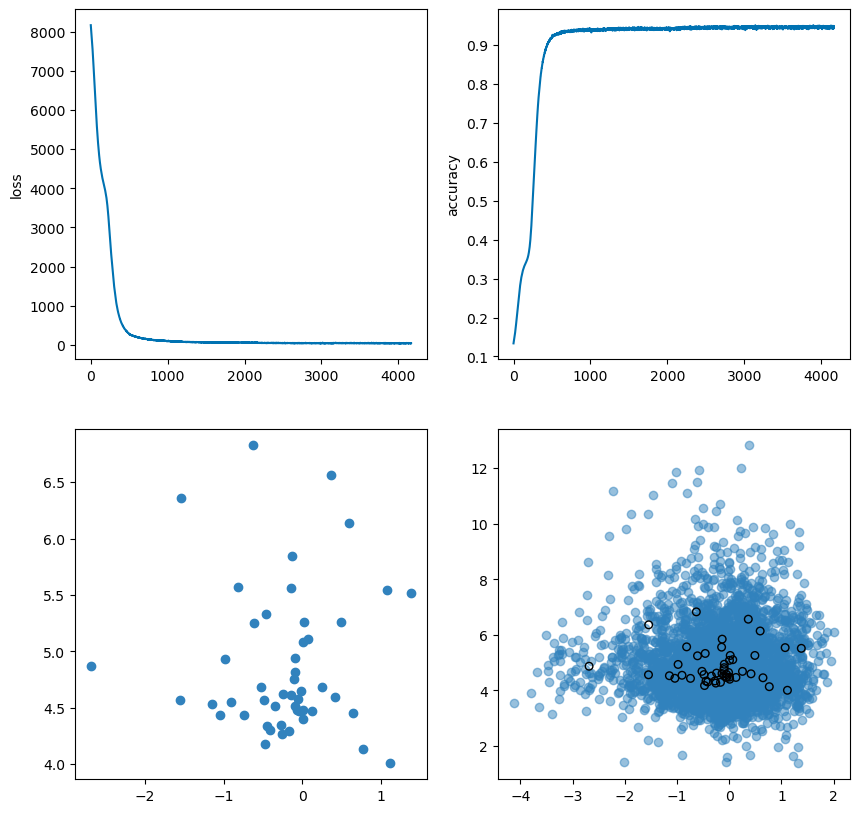

In [9]:
import time
import os
import argparse

def main():
#     ## Arguments 
#     parser = argparse.ArgumentParser(description='PiCoHaemoGen: PacBio-integrated Computational Pipeline for Haemosporida Mitochondrial Genome Analysis')
#     ### main arguments
#     parser.add_argument('-rR', '--rawReads', type=str, help="rawReads from PacBio sequencing", required=True)
#     ### readsRedirection arguments
#     parser.add_argument('-pF', '--primerF', type=str, help="primerF 5'-3'", default='GATTCTCTCCACACTTCAATTCGTACTTC')
#     parser.add_argument('-pR', '--primerR', type=str, help="primerR 5'-3'", default='GAAGTACGAATTGAAGTGTGGAGAGAATC')

#     args = parser.parse_args()

    ## files
    #rawReads = args.rawReads
    rawReads = "AE100.fasta"
    ## run readsRedirection
    #primerF = args.primerF
    #primerR = args.primerR
    primerF = 'GATTCTCTCCACACTTCAATTCGTACTTC'
    primerR = 'GAAGTACGAATTGAAGTGTGGAGAGAATC'
    primerDetection(rawReads, primerF, primerR)

    ## run raw aligment
    mafftRawOut= str(rawReads).split(".")[0] + "_nolong.fasta"
    mafftRaw(mafftRawOut)

    ## run convert DNA seq to Binary format
    fasta2binOut= str(rawReads).split(".")[0] + "_mafftRaw.fasta"
    fasta2bin(fasta2binOut)

    ## run VAE program and clustering
    VAErunOut = str(rawReads).split(".")[0] + "_bin.txt"
    mu, VAErunData = VAE_model(VAErunOut)
    nameCluster = str(rawReads).split(".")[0]
    extract_cluster_labels_dbscan (mu, VAErunData, nameCluster)

    txtCluster = [f for f in os.listdir() if f.endswith('-.txt') and f.startswith(nameCluster)]
    for headers_file in txtCluster:
        mapped_output_file = headers_file.split(".")[0] + ".fa"
        txt2fasta(rawReads, headers_file, mapped_output_file)

    ## run final aligment
    filesM = [f for f in os.listdir() if f.endswith('.fa')]

    mafftFinal(filesM)

    ## polishing output
    filesFinal = [f for f in os.listdir() if f.endswith('_mafftFinal.fasta')]
    polishing(filesFinal)

    ## removing temporal files
#     for file in os.listdir():
#         file_path = file
#         if file.endswith(".txt") \
#             or file.endswith("_mafftFinal.fasta")\
#             or file.endswith("_corrected.fasta") \
#             or file.endswith(".fa")\
#             or file.endswith("_mafftRaw.fasta") \
#             or file.endswith("_nolong.fasta"):
#             if os.path.exists(file_path):
#                 os.remove(file_path)
#                 print(f"Temporal file has been deleted {file_path}.")
#             else:
#                 print(f"Temporal file does not exist {file_path}.")

if __name__ == '__main__':
    main()